# Feature Exploration

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

Get all dataloaders from the train/test data
```python
next(iter(dataloader))
```

In [5]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

In [6]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')

ignore_vars = ['ndvi', 'p84.162', 'sp', 'tp', 'Eb']
ds = xr.merge([ds, d_])
ds = ds[[v for v in ds.data_vars if v not in ignore_vars]]

In [7]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# What data do we have?

In [8]:
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 449)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2018-12-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    VCI      (time, lat, lon) float64 39.36 18.57 19.15 ... 21.15 60.27 22.19
    pev      (time, lat, lon) float64 -0.006845 -0.006982 -0.006779 ... nan nan
    t2m      (time, lat, lon) float64 296.8 297.3 296.2 294.4 ... nan nan nan
    precip   (time, lat, lon) float64 2.911e-08 2.504e-08 0.2845 ... nan nan nan
    E        (time, lat, lon) float64 14.84 10.96 10.96 7.992 ... nan nan nan
    SMroot   (time, lat, lon) float64 0.2158 0.2149 0.2149 ... nan nan nan
    SMsurf   (time, lat, lon) float64 0.2084 0.2109 0.2109 ... nan nan nan

In [130]:
import pickle

with open(data_dir.parents[0] / 'one_month_forecast_ALL_ds.pkl', 'wb') as fp:
    pickle.dump(ds, fp)

# Build the dataframe

- https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/
- https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
- https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

In [103]:
VCI_pixels = ds.VCI.stack(pixel=['lat', 'lon']).transpose()
df = pd.DataFrame(VCI_pixels.values, columns=VCI_pixels.time, index=[p for p in range(VCI_pixels.shape[0])])
df['pixel'] = VCI_pixels.pixel.values
df['lat'] = VCI_pixels.lat.values
df['lon'] = VCI_pixels.lon.values

# pixel index
df['pixel_index'] = (~(df.pixel == df.pixel.shift(1))).cumsum()
pixels = df[['pixel_index', 'pixel', 'lat', 'lon']].drop_duplicates().set_index('pixel_index')

df = df.set_index(['pixel', 'pixel_index', 'lat', 'lon']).stack().reset_index().rename(columns={0: 'VCI'})

df.head(2)

,pixel,pixel_index,lat,lon,time,VCI
0,"(-5.0, 33.75)",1,-5.0,33.75,1981-08-31,39.360001
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499


In [104]:
dfs = []
for var in [v for v in ds.data_vars if v != 'VCI']:
    dfs.append((
        ds[var]
        .stack(pixel=['lat', 'lon'])
        .transpose()
        .drop('pixel')
        .to_dataframe()
        .reset_index()
        .drop(columns=['time', 'pixel'])
    ))

df2 = pd.concat(dfs, axis=1)
df = df.join(df2)

# time index
times = pd.unique(df.time.ravel())
times = pd.Series(np.arange(len(times)), times)
df['time_index'] = df.time.apply(times.get)

df.head(2)

,pixel,pixel_index,lat,lon,time,VCI,pev,t2m,precip,E,SMroot,SMsurf,time_index
0,"(-5.0, 33.75)",1,-5.0,33.75,1981-08-31,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432,0
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334,1


In [105]:
#### Add the lagged variables
for var_ in [v for v in ds.data_vars]:
    df[f'next_month_{var_}'] = (
        lag.sort_values('time').groupby(['pixel_index'])[var_].shift(1)
        .reset_index().sort_values('index').set_index('index')
    )

df.head(2)

,pixel,pixel_index,lat,lon,time,VCI,pev,t2m,precip,E,SMroot,SMsurf,time_index,next_month_VCI,next_month_pev,next_month_t2m,next_month_precip,next_month_E,next_month_SMroot,next_month_SMsurf
0,"(-5.0, 33.75)",1,-5.0,33.75,1981-08-31,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334,1,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432


In [118]:
# Only if required create the (time, [variable, pixel #]) dataframe
if False:
    df_ts = (
        df.set_index(['time', 'pixel_index'])
        .drop(columns=['pixel', 'time_index', 'lat', 'lon'])
        .stack().unstack(-2)
        .reset_index().set_index('time')
        .rename(columns={'level_1': 'variable'})
    )
    display(df_ts.head())
    df_ts.shape

### Get the times where we have all the data!

In [107]:
print(df.shape)
df_clean = df.dropna(how='any')
print(df.shape)

(629094, 20)
(629094, 20)


In [108]:
# get a smaller subset to play with
d = df_clean.loc[np.isin(df.pixel_index, [i for i in range(10)])]
d.shape

(3978, 20)

### Alternative format

```python
pd.DataFrame({
    'time': df.time.iloc[:20],
    'variable': np.tile(np.array([v for v in ds.data_vars]), 5)[:20],
    0: np.random.rand(20),
    1: np.random.rand(20),
    2: np.random.rand(20),
})
```

```
time	variable	0	1	2
0	1981-08-31	VCI	0.078587	0.457228	0.008751
1	1981-09-30	pev	0.345580	0.356264	0.116740
2	1981-10-31	t2m	0.876523	0.509587	0.885240
3	1981-11-30	precip	0.701764	0.042951	0.111743
4	1981-12-31	E	0.507153	0.244528	0.055843

```

In [15]:
# pixels
# df.head(30).set_index(['time'] + [v for v in ds.data_vars]).stack().unstack(-2)
# df.head(30).melt(id_vars=['time'] + [v for v in ds.data_vars])

# What does the data look like?

In [65]:
from sklearn.model_selection import train_test_split
import tsfresh
from scipy.stats import pearsonr

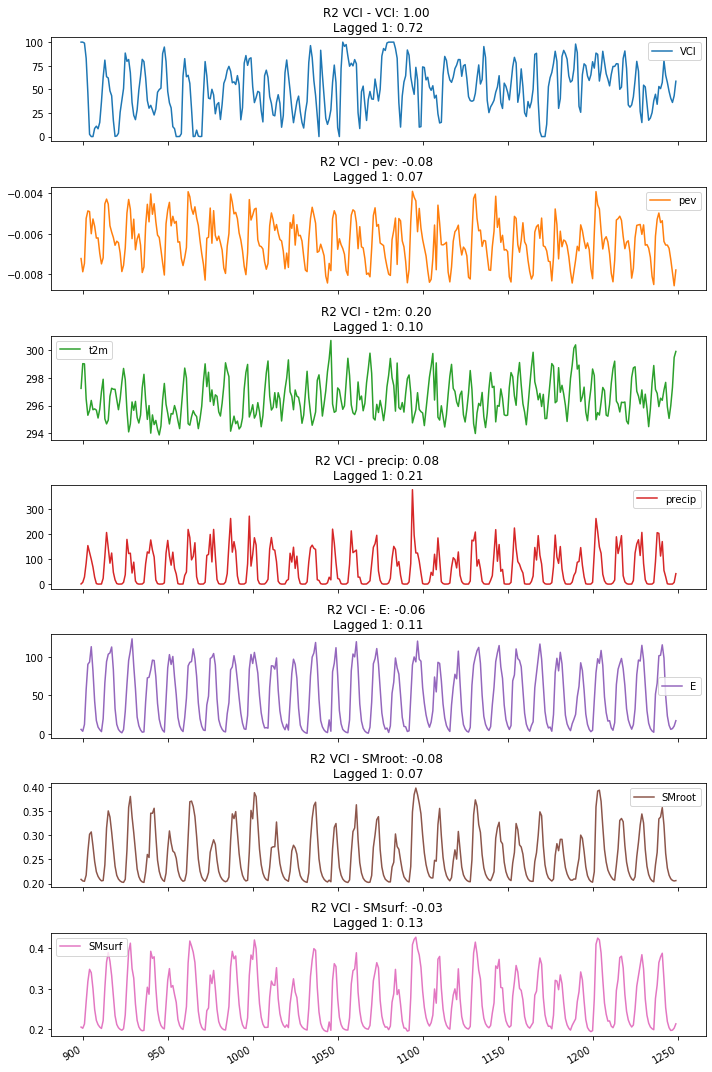

In [110]:
# Plot a single Pixel
pixel_id = 3
data = df_clean.loc[df_clean['pixel_index'] == pixel_id]

vars_ = [v for v in ds.data_vars]

# get the pearsons correlation 
corrs = []
vci_df = data.loc[:, ['VCI', 'time']].set_index('time')
t1 = vci_df.values.flatten()

for var in vars_:
    ts2 = data[[var, 'time']].set_index('time')
    t2 = ts2.values.flatten()
    mask = np.isnan(vci_df.values.flatten()) & np.isnan(ts2.values.flatten())

    r, _ = pearsonr(t1, t2)
    corrs.append(r)
#     print(f'VCI - {var}: {r:.2f}')

# GET LAGGED correlations
lagged_corrs = []
for var in vars_:
    ts2 = data[[var, 'time']].set_index('time').shift(-1)
    t2 = ts2.values.flatten()
    mask = ~(np.isnan(t1) | np.isnan(t2))

    r, _ = pearsonr(t1[mask], t2[mask])
    lagged_corrs.append(r)
#     print(f'VCI - {var} Lagged 1: {r:.2f}')

# plot each time series
data.loc[:, vars_].plot(
    subplots=True, sharex=True, figsize=(10, 15)
)
fig = plt.gcf()
pixel = np.unique(df_clean.pixel.loc[df_clean.pixel_index == pixel_id])[0]

axes = fig.get_axes()
[
    axes[i].set_title(
        f'R2 VCI - {vars_[i]}: {corrs[i]:.2f} \nLagged 1: {lagged_corrs[i]:.2f}') 
        for i in range(len([v for v in ds.data_vars])
    )
]

plt.tight_layout()
plt.show()

#### What do the marginal distributions of the variables look like?

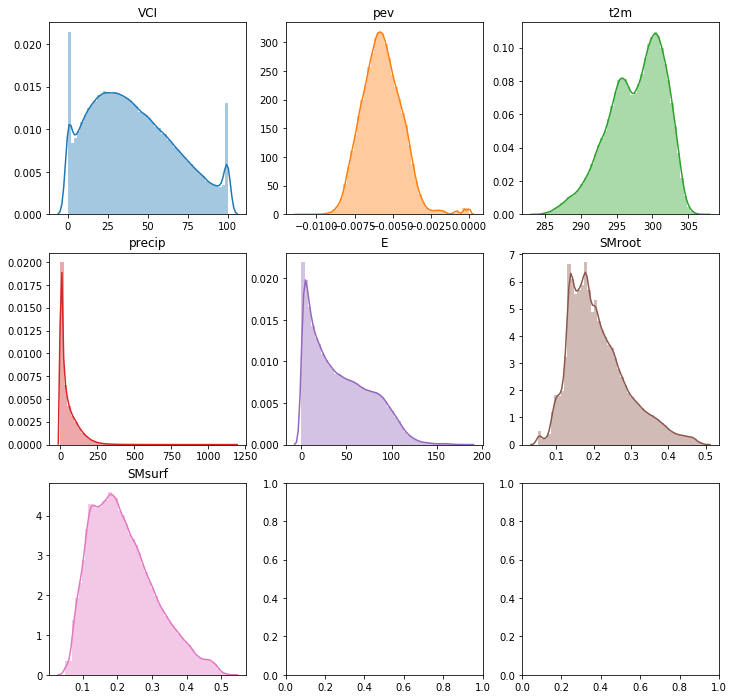

In [124]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

xlim_dict = {}
ylim_dict = {}

for i, column in enumerate(df_clean[[v for v in ds.data_vars]].columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(df_clean[column][~df_clean[column].isna()].values, ax=ax, color=colors[i])
    ax.set_title(column)
    xlim_dict[column] = ax.get_xlim()
    ylim_dict[column] = ax.get_ylim()
    




In [ ]:
# try and wrap into a function

def plot_variable_distributions(data, xlim_dict=None, ylim_dict=None, vars_=[v for v in ds.data_vars], show_all_data=False):
    xlim_dict = {} if xlim_dict == None else xlim_dict
    ylim_dict = {} if ylim_dict == None else ylim_dict
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    colors = sns.color_palette()

    for i, column in enumerate(data.columns):
        ax_ix = np.unravel_index(i, (3, 3))
        ax = axes[ax_ix]
        sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
        
        if show_all_data:
            sns.distplot(
                df_clean[column][~df_clean[column].isna()].values, ax=ax, color='grey', 
                hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
            )

        ax.set_title(column)
        ax.set_ylim(ylim_dict[column])
        ax.set_xlim(xlim_dict[column])
        xlim_dict[column] = ax.get_xlim()
        ylim_dict[column] = ax.get_ylim()
    
    return fig, xlim_dict, ylim_dict


# plot_variable_distributions(
#     data=df_clean
# )

#### That's great but is there any signal in the other features which can give us some information about the status of the VCI? Let's compare the CONDITIONAL distributions of the variables given a VCI of < 10.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df_clean.loc[df_clean.VCI < 10, [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df_clean[column][~df_clean[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### What about the distribution of variables LAGGED by 1 month?
- Display the distribution of the variables on the MONTH BEFORE the VCI was low (< 10)
- Visualise the conditional distribution against the marginal distribution (the grey line)

In [109]:
# # create month+1 VCI variable
# lag = df_clean.copy()
# lag['next_month_VCI'] = (
#     lag.sort_values('time').groupby(['pixel_index'])['VCI'].shift(1)
#     .reset_index().sort_values('index').set_index('index')
# )
display(df_clean.head(2))

,pixel,pixel_index,lat,lon,time,VCI,pev,t2m,precip,E,SMroot,SMsurf,time_index,next_month_VCI,next_month_pev,next_month_t2m,next_month_precip,next_month_E,next_month_SMroot,next_month_SMsurf
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499,-0.007329,297.860565,1.686568,8.694020,0.208080,0.201334,1,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432
2,"(-5.0, 33.75)",1,-5.0,33.75,1981-10-31,50.107499,-0.008037,299.804291,11.365343,6.438349,0.204618,0.198097,2,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334


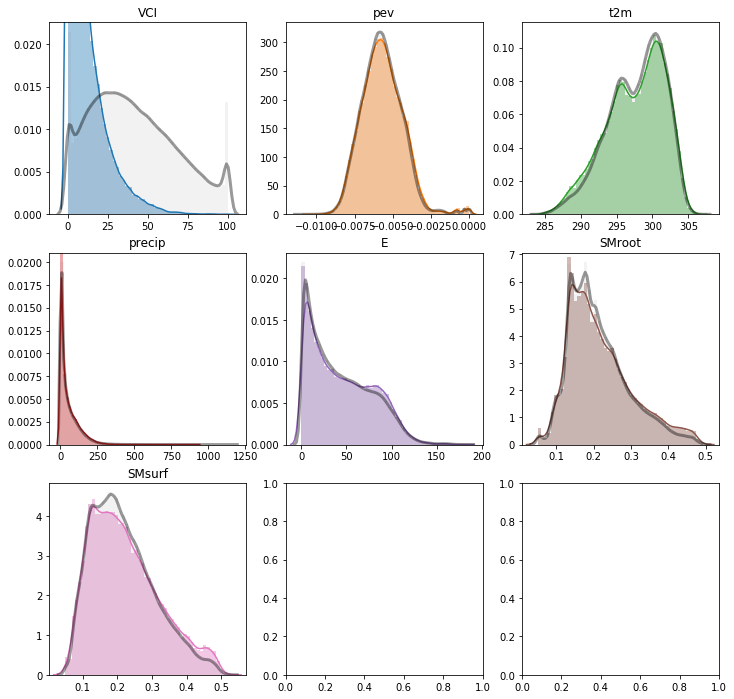

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = lag.loc[lag.next_month_VCI < 10, [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])

#### What about being conditional on low rainfall values?

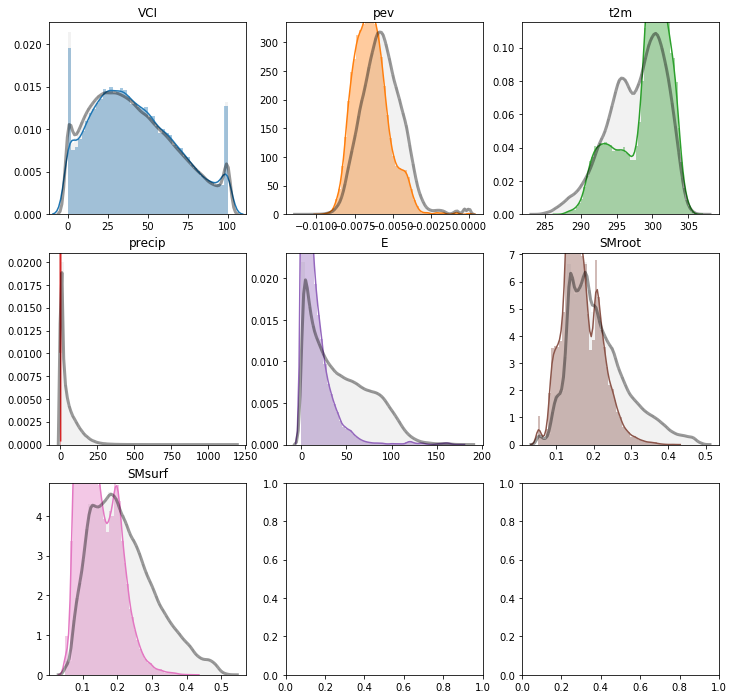

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df.loc[df.precip < df.precip.quantile(0.1), [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### and the same with the precip lagged one month

In [111]:
display(df_clean.head(2))

,pixel,pixel_index,lat,lon,time,VCI,pev,t2m,precip,E,SMroot,SMsurf,time_index,next_month_VCI,next_month_pev,next_month_t2m,next_month_precip,next_month_E,next_month_SMroot,next_month_SMsurf
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499,-0.007329,297.860565,1.686568,8.694020,0.208080,0.201334,1,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432
2,"(-5.0, 33.75)",1,-5.0,33.75,1981-10-31,50.107499,-0.008037,299.804291,11.365343,6.438349,0.204618,0.198097,2,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334


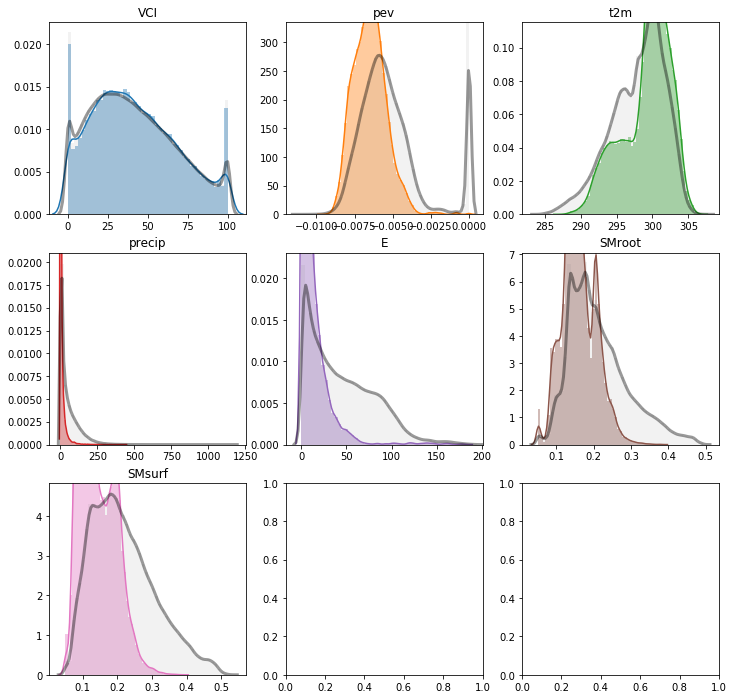

In [113]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df_clean.loc[df_clean.next_month_precip < df_clean.precip.quantile(0.1), [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### What about lagged LOW temperature?

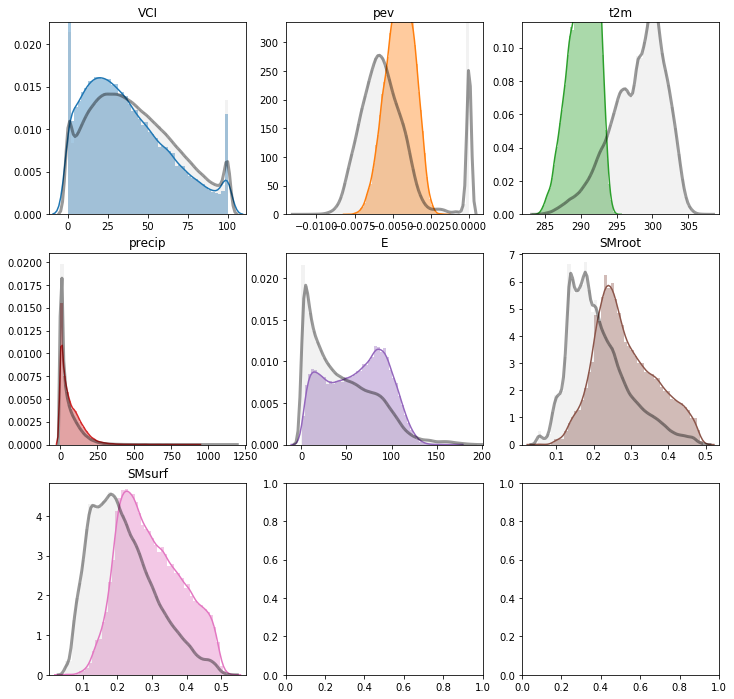

In [115]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df_clean.loc[df_clean.next_month_t2m < df_clean.t2m.quantile(0.1), [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### lagged HIGH temperature?

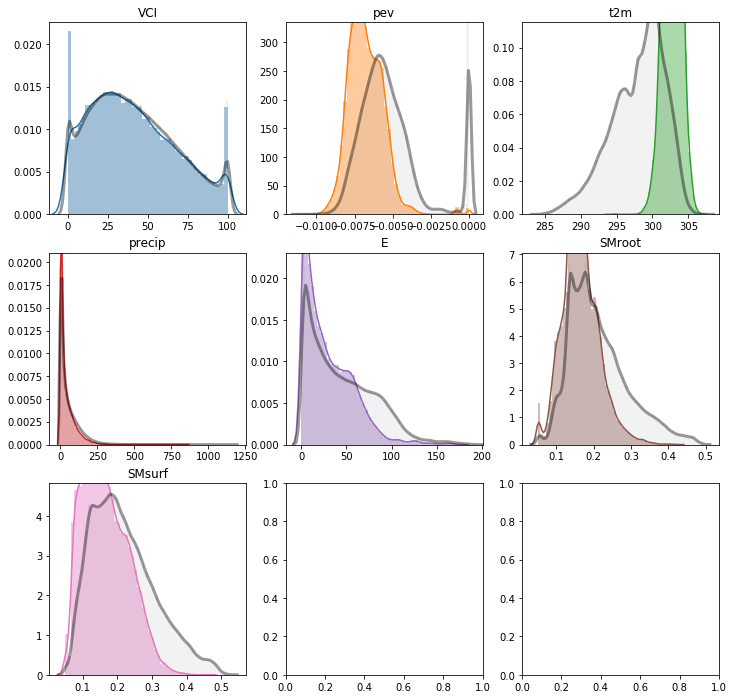

In [119]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df_clean.loc[df_clean.next_month_t2m > df_clean.t2m.quantile(0.9), [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### Current temperature

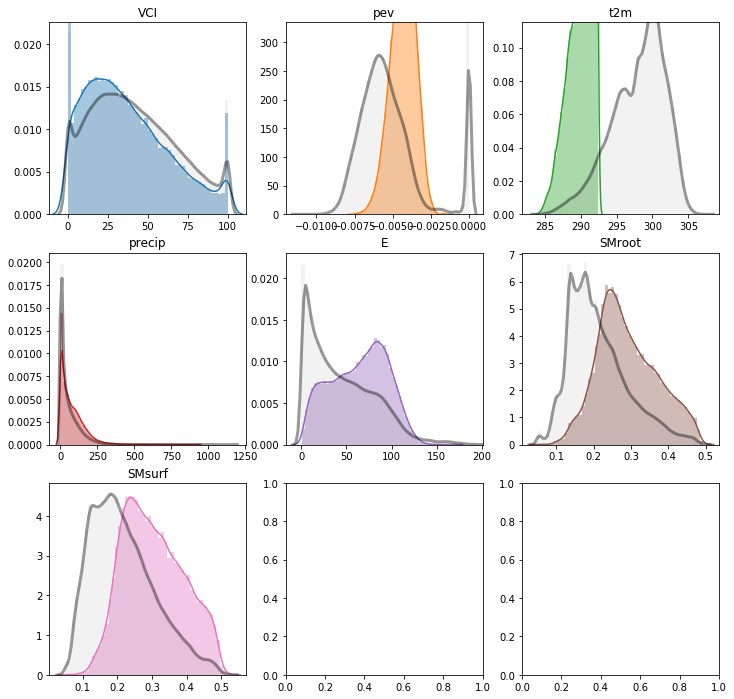

In [121]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

# data = df_clean.loc[df_clean.t2m > df_clean.t2m.quantile(0.9), [v for v in ds.data_vars]]
data = df_clean.loc[df_clean.t2m < df_clean.t2m.quantile(0.1), [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])

# Measuring time series correlations
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
- Pearsons Correlation
- Pearson's correlation in a window of the data
- Time lagged cross correlation
- windowed time lagged cross correlations
- Dynamic Time Warping

[Fast FFT based TLCC](https://lexfridman.com/fast-cross-correlation-and-time-series-synchronization-in-python/)


In [127]:
# pearson's correlation (global)
corrs = []
vci_df = df_clean.loc[:, ['VCI', 'time']].set_index('time')
t1 = vci_df.values.flatten()

for var in vars_:
    ts2 = df_clean[[var, 'time']].set_index('time')
    t2 = ts2.values.flatten()
    mask = np.isnan(vci_df.values.flatten()) & np.isnan(ts2.values.flatten())

    r, _ = pearsonr(t1[~mask], t2[~mask])
    corrs.append(r)

In [ ]:
# Pixel based correlations


In [117]:
# pearson's windowed correlation

# Set window size to compute moving window synchrony.
r_window_size = 3

# Interpolate missing data.
# df_interpolated = df.interpolate()

# Compute rolling window synchrony
rolling_r = df_interpolated['S1_Joy'].rolling(window=r_window_size, center=True).corr(df_interpolated['S2_Joy'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")


NameError: name 'df_interpolated' is not defined

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


# X and y data
For time series:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [142]:
from sklearn.model_selection import TimeSeriesSplit

from tsfresh import extract_features, extract_relevant_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [140]:
# df['id'] = df.index
# X = df[[v for v in ds.data_vars if v != 'VCI'] + ['pixel_index', 'time_index', 'id']]
# y = df.set_index('id')['VCI']  # [['VCI'] + ['pixel_index', 'time_index']]

d = d.loc[d.pixel_index == 1]
d['id'] = d.index
X = d[[v for v in ds.data_vars if v != 'VCI'] + ['pixel_index', 'time_index', 'id']]
y = d.set_index('id')['VCI']  # [['VCI'] + ['pixel_index', 'time_index']]


display(X.head(2))
display(y.head(2))

print("X: ", X.shape)
print("y: ", y.shape)

,pev,t2m,precip,E,SMroot,SMsurf,pixel_index,time_index,id
1,-0.007329,297.860565,1.686568,8.694020,0.208080,0.201334,1,1,1
2,-0.008037,299.804291,11.365343,6.438349,0.204618,0.198097,1,2,2


id
1    50.802499
2    50.107499
Name: VCI, dtype: float64


X:  (351, 9)
y:  (351,)


In [137]:
# df_ts.loc[df_ts.variable == 'VCI']

### play with tsfresh
https://tsfresh.readthedocs.io/en/latest/text/forecasting.html

In [143]:
if (data_dir.parents[0] / 'subset_filtered_features_df.pkl').exists():
    with open(data_dir.parents[0] / 'subset_filtered_features_df.pkl', 'rb') as fp:
        filtered_features = pickle.load(fp)
else:
    filtered_features = extract_relevant_features(X, y, column_id='id', column_sort='time_index')
    with open(data_dir.parents[0] / 'subset_filtered_features_df.pkl', 'wb') as fp:
        pickle.dump(filtered_features, fp)

filtered_features.head(2)

Feature Extraction: 100%|██████████| 10/10 [02:12<00:00, 11.50s/it]
 'E__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'E__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"' ...
 't2m__spkt_welch_density__coeff_2' 't2m__spkt_welch_density__coeff_5'
 't2m__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


variable,precip__abs_energy,"precip__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20","precip__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5","precip__fft_coefficient__coeff_0__attr_""abs""","precip__fft_coefficient__coeff_0__attr_""real""",precip__maximum,precip__mean,precip__median,precip__minimum,precip__quantile__q_0.1,...,SMsurf__quantile__q_0.1,SMsurf__quantile__q_0.2,SMsurf__quantile__q_0.3,SMsurf__quantile__q_0.4,SMsurf__quantile__q_0.6,SMsurf__quantile__q_0.7,SMsurf__quantile__q_0.8,SMsurf__quantile__q_0.9,"SMsurf__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10",SMsurf__abs_energy
id,,,,,,,,,,,,,,,,,,,,,
1,2.844510,0.327093,0.654185,1.686568,1.686568,1.686568,1.686568,1.686568,1.686568,1.686568,...,0.201334,0.201334,0.201334,0.201334,0.201334,0.201334,0.201334,0.201334,0.055220,0.040535
2,129.171024,2.204192,4.408384,11.365343,11.365343,11.365343,11.365343,11.365343,11.365343,11.365343,...,0.198097,0.198097,0.198097,0.198097,0.198097,0.198097,0.198097,0.198097,0.054332,0.039242


In [146]:
filtered_features

variable,precip__abs_energy,"precip__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20","precip__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5","precip__fft_coefficient__coeff_0__attr_""abs""","precip__fft_coefficient__coeff_0__attr_""real""",precip__maximum,precip__mean,precip__median,precip__minimum,precip__quantile__q_0.1,...,SMsurf__quantile__q_0.1,SMsurf__quantile__q_0.2,SMsurf__quantile__q_0.3,SMsurf__quantile__q_0.4,SMsurf__quantile__q_0.6,SMsurf__quantile__q_0.7,SMsurf__quantile__q_0.8,SMsurf__quantile__q_0.9,"SMsurf__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10",SMsurf__abs_energy
id,,,,,,,,,,,,,,,,,,,,,
1,2.844510e+00,3.270925e-01,6.541851e-01,1.686568e+00,1.686568e+00,1.686568e+00,1.686568e+00,1.686568e+00,1.686568e+00,1.686568e+00,...,0.201334,0.201334,0.201334,0.201334,0.201334,0.201334,0.201334,0.201334,0.055220,0.040535
2,1.291710e+02,2.204192e+00,4.408384e+00,1.136534e+01,1.136534e+01,1.136534e+01,1.136534e+01,1.136534e+01,1.136534e+01,1.136534e+01,...,0.198097,0.198097,0.198097,0.198097,0.198097,0.198097,0.198097,0.198097,0.054332,0.039242
3,4.893875e+02,4.290356e+00,8.580712e+00,2.212210e+01,2.212210e+01,2.212210e+01,2.212210e+01,2.212210e+01,2.212210e+01,2.212210e+01,...,0.212813,0.212813,0.212813,0.212813,0.212813,0.212813,0.212813,0.212813,0.058369,0.045289
4,1.767665e+04,2.578499e+01,5.156997e+01,1.329536e+02,1.329536e+02,1.329536e+02,1.329536e+02,1.329536e+02,1.329536e+02,1.329536e+02,...,0.289586,0.289586,0.289586,0.289586,0.289586,0.289586,0.289586,0.289586,0.079426,0.083860
5,2.725624e+04,3.201842e+01,6.403683e+01,1.650946e+02,1.650946e+02,1.650946e+02,1.650946e+02,1.650946e+02,1.650946e+02,1.650946e+02,...,0.320928,0.320928,0.320928,0.320928,0.320928,0.320928,0.320928,0.320928,0.088022,0.102995
6,1.892950e+04,2.668311e+01,5.336622e+01,1.375845e+02,1.375845e+02,1.375845e+02,1.375845e+02,1.375845e+02,1.375845e+02,1.375845e+02,...,0.355562,0.355562,0.355562,0.355562,0.355562,0.355562,0.355562,0.355562,0.097521,0.126424
7,1.580527e+04,2.438191e+01,4.876383e+01,1.257190e+02,1.257190e+02,1.257190e+02,1.257190e+02,1.257190e+02,1.257190e+02,1.257190e+02,...,0.339140,0.339140,0.339140,0.339140,0.339140,0.339140,0.339140,0.339140,0.093017,0.115016
8,6.601672e+03,1.575774e+01,3.151547e+01,8.125067e+01,8.125067e+01,8.125067e+01,8.125067e+01,8.125067e+01,8.125067e+01,8.125067e+01,...,0.310640,0.310640,0.310640,0.310640,0.310640,0.310640,0.310640,0.310640,0.085200,0.096497
9,3.612336e+02,3.686048e+00,7.372095e+00,1.900615e+01,1.900615e+01,1.900615e+01,1.900615e+01,1.900615e+01,1.900615e+01,1.900615e+01,...,0.272203,0.272203,0.272203,0.272203,0.272203,0.272203,0.272203,0.272203,0.074658,0.074095


### play with models

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

### Play with prophet

In [131]:
df.head()

,pixel,pixel_index,lat,lon,time,VCI,pev,t2m,precip,E,SMroot,SMsurf,time_index,next_month_VCI,next_month_pev,next_month_t2m,next_month_precip,next_month_E,next_month_SMroot,next_month_SMsurf
0,"(-5.0, 33.75)",1,-5.0,33.75,1981-08-31,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334,1,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432
2,"(-5.0, 33.75)",1,-5.0,33.75,1981-10-31,50.107499,-0.008037,299.804291,1.136534e+01,6.438349,0.204618,0.198097,2,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334
3,"(-5.0, 33.75)",1,-5.0,33.75,1981-11-30,46.427999,-0.007395,299.247986,2.212210e+01,16.903798,0.204654,0.212813,3,50.107499,-0.008037,299.804291,1.136534e+01,6.438349,0.204618,0.198097
4,"(-5.0, 33.75)",1,-5.0,33.75,1981-12-31,72.150000,-0.005308,296.316742,1.329536e+02,68.801471,0.232705,0.289586,4,46.427999,-0.007395,299.247986,2.212210e+01,16.903798,0.204654,0.212813


In [135]:
df[['pixel_index', 'time', 'VCI']].rename(columns=dict(zip(['time', 'VCI'], ['ds', 'y'])))

,pixel_index,ds,y
0,1,1981-08-31,39.360001
1,1,1981-09-30,50.802499
2,1,1981-10-31,50.107499
3,1,1981-11-30,46.427999
4,1,1981-12-31,72.150000
5,1,1982-01-31,93.319998
6,1,1982-02-28,99.632500
7,1,1982-03-31,91.073999
8,1,1982-04-30,59.599998
9,1,1982-05-31,33.867999
